这个文档用来分析study'TIMs_Hetero_tempsweep_Task_Pareto'上获得帕累托的点的TIMs，以及任务表现（目前仅有NARMA-10）

预期：1. 画出帕累托前沿点；见文件夹；2.查看帕累托前沿上的点的TIMs

In [3]:
import sys
import os
import glob
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
from Plotting import plot_style_config
from Plotting import ParetoFront_Plotting


In [4]:
def load_and_merge_data(folder_path, file_pattern, columns_of_interest=None):
    """
    参数:
    folder_path: 数据文件夹路径 (可以是相对路径)
    file_pattern: 文件名前缀匹配模式 (例如 'result_MC_heterogeneous')
    columns_of_interest: 需要保留的列名列表 (例如 ['temp', 'MC']), None则保留所有
    
    返回:
    merged_df: 合并后的完整 DataFrame，包含一列 'Legend_Label'
    """
    # 1. 设置路径 (自动处理 Windows/Mac 路径分隔符)
    # 假设当前 notebook 在 Analysis 文件夹，数据在同级的 pareto... 文件夹
    # resolve() 会把 '..' 转换成绝对路径，避免路径混乱
    base_dir = Path.cwd() 
    target_dir = (base_dir / folder_path).resolve()
    
    # 2. 查找文件
    # glob 搜索指定 pattern 开头的 csv 文件
    search_pattern = f"{file_pattern}*.csv"
    files = list(target_dir.glob(search_pattern))
    
    if not files:
        print(f"警告: 在 {target_dir} 中没有找到匹配 '{search_pattern}' 的文件")
        return pd.DataFrame()

    data_list = []
    
    print(f"找到 {len(files)} 个文件，开始处理...")

    for file in files:
        # 3. 解析文件名提取 Legend (核心逻辑)
        # 文件名示例: result_KRandGR_heterogeneous_1_n4_...
        # split('_') 按照下划线分割
        try:
            filename_parts = file.stem.split('_')
            # 根据你的需求：提取第三个下划线后面的内容 (索引为 3)
            #索引: 0      1       2             3
            #内容: result KRandGR heterogeneous 1
            legend_val = filename_parts[3]
        except IndexError:
            legend_val = "Unknown" # 防止文件名格式不一致报错
            
        # 4. 读取数据
        df = pd.read_csv(file)
        
        # 5. 筛选列 (如果指定了列名)
        if columns_of_interest:
            # 取交集，防止某些列不存在导致报错
            valid_cols = [c for c in columns_of_interest if c in df.columns]
            df = df[valid_cols]
            
        # 6. 【优雅的关键】将提取的 Legend 作为一个新列加入数据
        df['number'] = legend_val
        
        data_list.append(df)
        
    # 7. 合并所有数据
    if data_list:
        merged_df = pd.concat(data_list, ignore_index=True)
        # 可选：如果 legend 是数字，转为数字类型以便排序
        try:
            merged_df['number'] = pd.to_numeric(merged_df['number'])
            merged_df = merged_df.sort_values('number') # 按图例顺序排序
        except ValueError:
            pass # 如果不是数字，保持字符串原样
            
        return merged_df
    else:
        return pd.DataFrame()
    
    
    

In [5]:
# 设定参数
folder_loc = "../paretofront_points_TIMs_NARMA10" # 相对路径
pattern = "result_MC_heterogeneous"
cols_needed = ['temp', 'MC'] # 假设你需要这两列，根据实际情况修改

# 调用函数
df_all = load_and_merge_data(folder_loc, pattern, cols_needed)

# 检查数据
print(df_all.head())
print(f"包含的图例标签: {df_all['number'].unique()}")

找到 11 个文件，开始处理...
    temp        MC  number
48  20.1  4.937483       1
49  20.2  4.974730       1
50  20.3  4.954238       1
51  20.4  4.964111       1
52  20.5  5.013663       1
包含的图例标签: [ 1  2  3  4  5  6  7  8  9 10 11]


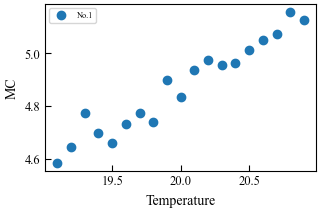

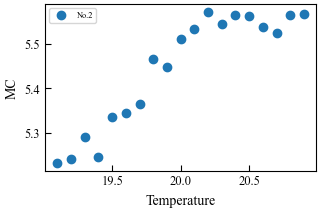

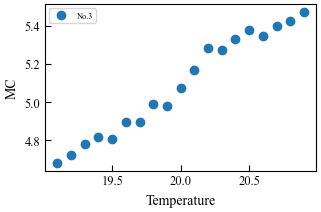

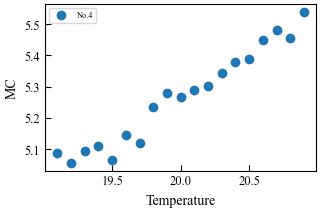

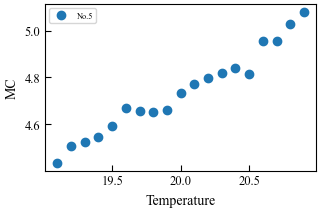

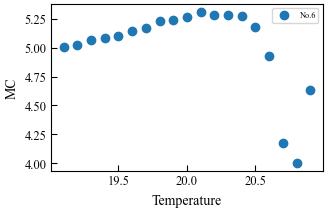

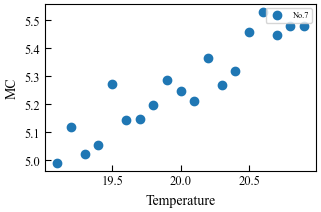

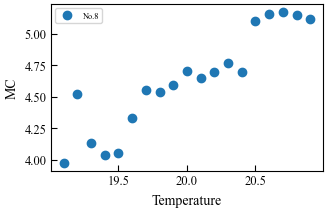

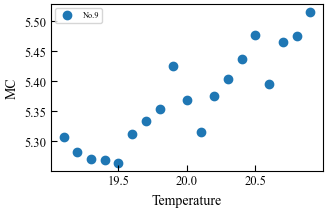

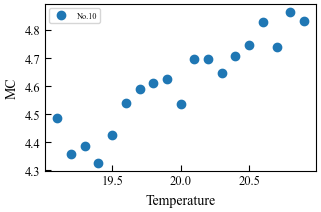

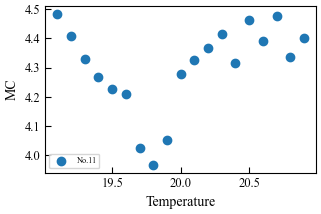

In [9]:
# 开始画图
plot_style_config.set_pub_style()
 # 修正了括号

# 获取所有唯一的标签
labels = df_all['number'].unique()

# 循环遍历每一个标签，单独画一条线
for label in labels:

    plt.figure(figsize=plot_style_config.get_figsize('single'))
    # 筛选出当前标签的数据
    subset = df_all[df_all['number'] == label]
    
    plt.scatter(
        subset['temp'],
        subset['MC'],
        label=label,  # 这里使用标签作为图例
        marker='o',
        linewidth=1
    )

    plt.xlabel('Temperature')
    plt.ylabel('MC')
    plt.legend([f'No.{label}']) # 显示图例
    plt.show()


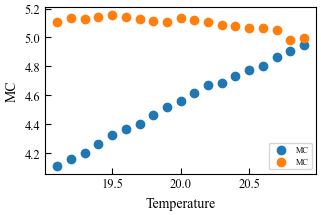

In [18]:
# 看下uniform的数据

filename1 = '../result_MC_uniform_tr19.03to21.08s0.1_bs16.78_bt20.0_temp_sweep.csv'
filename2 = '../result_MC_heterogeneous_n6_sr15to25_w0.16-0.2-0.2-0.15-0.1-0.18_tr19.03to21.08s0.1_bs20.0_bt20.0_temp_sweep.csv'
df_uniform = pd.read_csv(filename1)
df_heterogeneous = pd.read_csv(filename2)
plt.figure(figsize=plot_style_config.get_figsize('single'))
plt.scatter(
    df_uniform['temp'],
    df_uniform['MC'],
    label='MC',
    marker='o',
    linewidth=1
)
plt.scatter(
    df_heterogeneous['temp'],
    df_heterogeneous['MC'],
    label='MC',
    marker='o',
    linewidth=1
)
plt.xlabel('Temperature')
plt.ylabel('MC')
plt.legend()
plt.show()


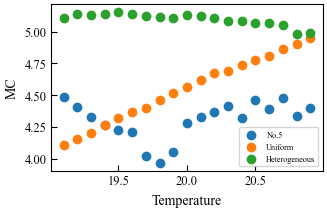

In [23]:
# 看看TIMs_Hetero_tempsweep_Task_Pareto中的储层的MC与thermal stability中的uniform和heterogeneous的MC比较
filename = '../paretofront_points_TIMs_NARMA10/result_MC_heterogeneous_11_n5_sr20to30_w0.27-0.13-0.34-0.033-0.22_tr19.03to21.08s0.1_bs20_bt20.0_temp_sweep.csv'

df_TIMs_Hetero_n5 = pd.read_csv(filename)
plt.figure(figsize=plot_style_config.get_figsize('single'))
plt.scatter(
    df_TIMs_Hetero_n5['temp'],
    df_TIMs_Hetero_n5['MC'],
    label='No.5',
    marker='o',
    linewidth=1
)
plt.scatter(
    df_uniform['temp'],
    df_uniform['MC'],
    label='Uniform',
    marker='o',
    linewidth=1
)
plt.scatter(
    df_heterogeneous['temp'],
    df_heterogeneous['MC'],
    label='Heterogeneous',
    marker='o',
    linewidth=1
)
plt.xlabel('Temperature')
plt.ylabel('MC')
plt.legend()
plt.show()




查看KRandGR的数据

In [12]:
# 设定参数
folder_loc = "../paretofront_points_TIMs_NARMA10" # 相对路径
pattern = "result_KRandGR_heterogeneous"
cols_needed = ['temp', 'CQ'] # 假设你需要这两列，根据实际情况修改

# 调用函数
df_all_KRandGR = load_and_merge_data(folder_loc, pattern, cols_needed)

# 检查数据
print(df_all_KRandGR.head())
print(f"包含的图例标签: {df_all_KRandGR['number'].unique()}")

找到 10 个文件，开始处理...
    temp  CQ  number
24  19.6   4       1
25  19.7   3       1
26  19.8   2       1
31  20.3  -1       1
27  19.9   0       1
包含的图例标签: [ 1  2  3  4  5  6  7  8  9 11]


<Figure size 350x216.316 with 0 Axes>

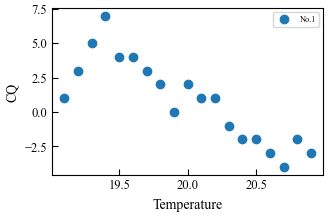

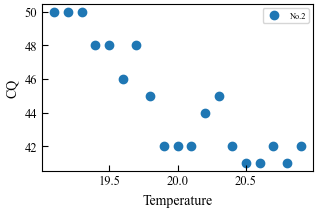

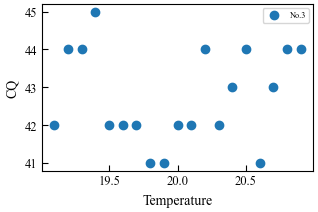

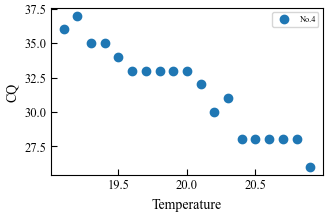

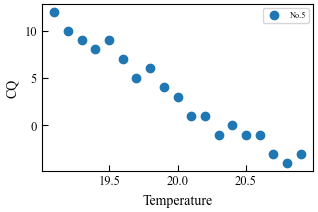

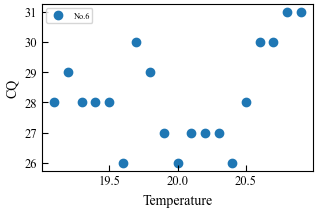

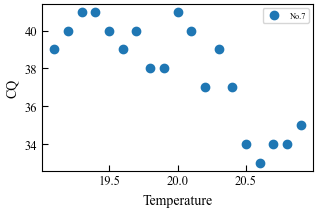

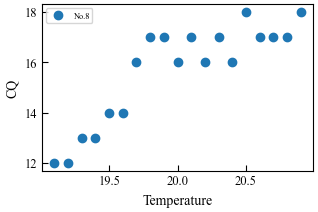

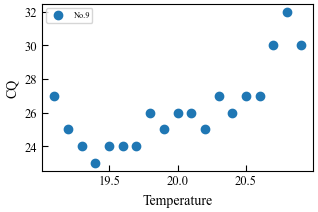

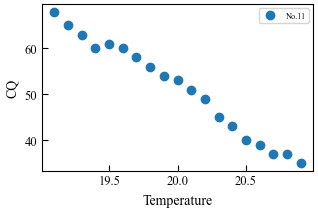

In [13]:
# 开始画图
plot_style_config.set_pub_style()
 # 修正了括号

# 获取所有唯一的标签
labels = df_all_KRandGR['number'].unique()

# 循环遍历每一个标签，单独画一条线
for label in labels:

    plt.figure(figsize=plot_style_config.get_figsize('single'))
    # 筛选出当前标签的数据
    subset_KRandGR = df_all_KRandGR[df_all_KRandGR['number'] == label]
    
    plt.scatter(
        subset_KRandGR['temp'],
        subset_KRandGR['CQ'],
        label=label,  # 这里使用标签作为图例
        marker='o',
        linewidth=1
    )

    plt.xlabel('Temperature')
    plt.ylabel('CQ')
    plt.legend([f'No.{label}']) # 显示图例
    plt.show()

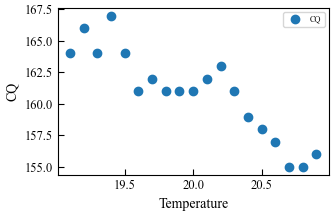

In [16]:
# 看看uniform的CQ
filename = '../result_KRandGR_uniform_tr19.03to21.08s0.1_bs16.78_bt20.0_temp_sweep.csv'
df_uniform = pd.read_csv(filename)
plt.figure(figsize=plot_style_config.get_figsize('single'))
plt.scatter(
    df_uniform['temp'],
    df_uniform['CQ'],
    label='CQ',
    marker='o',
    linewidth=1
)
plt.xlabel('Temperature')
plt.ylabel('CQ')
plt.legend()
plt.show()

各组的 MAD 结果: {np.int64(1): np.float64(3.140447311029255), np.int64(2): np.float64(1.9067075850994395), np.int64(3): np.float64(4.663985082310289), np.int64(4): np.float64(2.4543341755894947), np.int64(5): np.float64(3.131931029881115), np.int64(6): np.float64(4.803407547730557), np.int64(7): np.float64(2.531583206215892), np.int64(8): np.float64(6.598986678006237), np.int64(9): np.float64(1.2424726066356875), np.int64(10): np.float64(3.2946574767824264), np.int64(11): np.float64(2.816016722528097)}


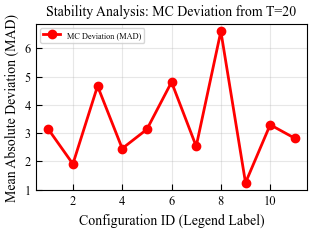

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from Plotting import plot_style_config

# 1. 准备存储结果的字典
mad_results = {}

# 建议：不要硬编码 np.arange(1, 12)，而是直接从数据中获取存在的 Legend
# lists = np.arange(1, 12, 1) 
lists = sorted(df_all['Legend_Label'].unique()) 

for i in lists:
    # 提取当前组的数据
    data = df_all[df_all['Legend_Label'] == i]
    
    # === 关键修改开始 ===
    
    # 1. 找到该组在 temp=20 时的基准 MC 值
    # 注意：这里假设每个组都有 temp=20 的数据
    try:
        ref_mc = data.loc[data['temp'] == 20.0, 'MC'].values[0]
    except IndexError:
        print(f"警告: 组 {i} 缺少 temp=20 的数据，跳过。")
        continue

    # 2. 计算 MAD (平均绝对偏差)
    # 公式: mean( |MC_current - MC_ref| )
    # mad_value = np.mean(np.abs(data['MC'] - ref_mc))
    
    # 如果你想用 MAPD (百分比偏差)，请用下面这行代替上面：
    mapd_value = np.mean(np.abs((data['MC'] - ref_mc) / ref_mc)) * 100
    
    # === 关键修改结束 ===
    
    mad_results[i] = mapd_value

print("各组的 MAD 结果:", mad_results)

# 3. 画图
plot_style_config.set_pub_style()
plt.figure(figsize=plot_style_config.get_figsize())

plt.plot(
    mad_results.keys(),   # X轴: 组号 (Legend)
    mad_results.values(), # Y轴: 偏差值 (MAD)
    label='MC Deviation (MAD)',
    color='red',          # 建议改个颜色区分于原始 MC
    marker='o',
    linestyle='-',
    linewidth=2 
)

# 4. 修正标签
plt.xlabel('Configuration ID (Legend Label)') # 之前是 Temperature，不对
plt.ylabel('Mean Absolute Deviation (MAD)')   # 之前是 MC，也不准确
plt.title('Stability Analysis: MC Deviation from T=20')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


<Figure size 350x216.316 with 0 Axes>

<Figure size 350x216.316 with 0 Axes>

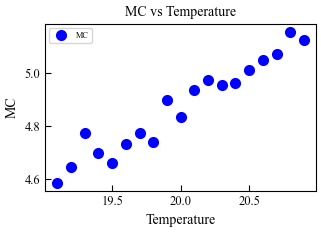

In [31]:
plt.figure(figsize=plot_style_config.get_figsize())
plt.scatter(
    data['temp'],
    data['MC'],
    label='MC',
    color='blue',
    marker='o',
    linestyle='-',
    linewidth=2
)
plt.xlabel('Temperature')
plt.ylabel('MC')
plt.title('MC vs Temperature')
plt.legend()
plt.show()